In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from typing import Tuple
import cv2

In [2]:
images = {
    "christmas_tree_6000x4000": "images/christmas_tree_6000x4000.png",
    "christmas_tree_600x400": "images/christmas_tree_600x400.png",
    "lenna_512x512": "images/lenna_512x512.png",
    "lenna_256x256": "images/lenna_256x256.png",
    "lenna_128x128": "images/lenna_128x128.png",
    "lenna_64x64": "images/lenna_64x64.png",
    "lenna_32x32": "images/lenna_32x32.png",
    "Barns_grand_tetons_1600x1195": "images/Barns_grand_tetons_1600x1195.png",
}


In [3]:
# image which should be encoded
image_path = images["lenna_32x32"]

# jpeg parameters
block_size: int = 8
subsampling_settings: Tuple[int, int, int] = (4, 2, 0)
# subsampling_settings: Tuple[int, int, int] = (4, 4, 4)  # can be (4,4,4) (4,4,2)
quantization_table_quality: int = 10  # can be one of: (100, 90, 50, 10)

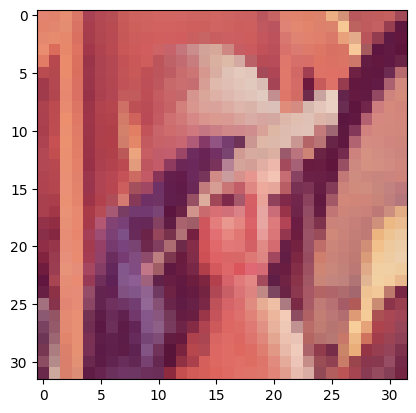

In [4]:
image = plt.imread(image_path)

fig, ax = plt.subplots()
ax.imshow(image, cmap="gray")

In [5]:
def plot_y_u_v(y_loc, u_loc, v_loc, colormap=True):
    fig_loc, ax_loc = plt.subplots(1, 3, figsize=(15, 20))
    ax_loc[0].imshow(y_loc, cmap="gray")
    ax_loc[0].set_title("Y Component")

    # creating a linear colormap, based on the values of the example https://commons.wikimedia.org/wiki/File:Barn-yuv.png
    if colormap:
        cmap_u = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0, 177 / 255, 78 / 255, 1),
                                                                          (0, 86 / 255, 169 / 255, 1)])
    else:
        cmap_u = matplotlib.colormaps["gray"]
    ax_loc[1].imshow(u_loc, cmap=cmap_u)
    ax_loc[1].set_title("U Component")

    if colormap:
        cmap_v = matplotlib.colors.LinearSegmentedColormap.from_list("", [(104 / 255, 151 / 255, 0, 1),
                                                                          (171 / 255, 84 / 255, 0)])
    else:
        cmap_v = matplotlib.colormaps["gray"]
    ax_loc[2].imshow(v_loc, cmap=cmap_v)
    ax_loc[2].set_title("V Component")
    plt.show()

In [6]:
def get_matrix(size=8):
    matr = []
    for i in range(size):
        matr.append(np.array(range(i * size, (i + 1) * size)))
    matr = np.array(matr)
    print(matr)

## Step 1 
### Colorspace Transformation

In [7]:
from jpeg_implementation.rgbToYuv import rgb_to_yuv

In [8]:
y, u, v = rgb_to_yuv(image=image)

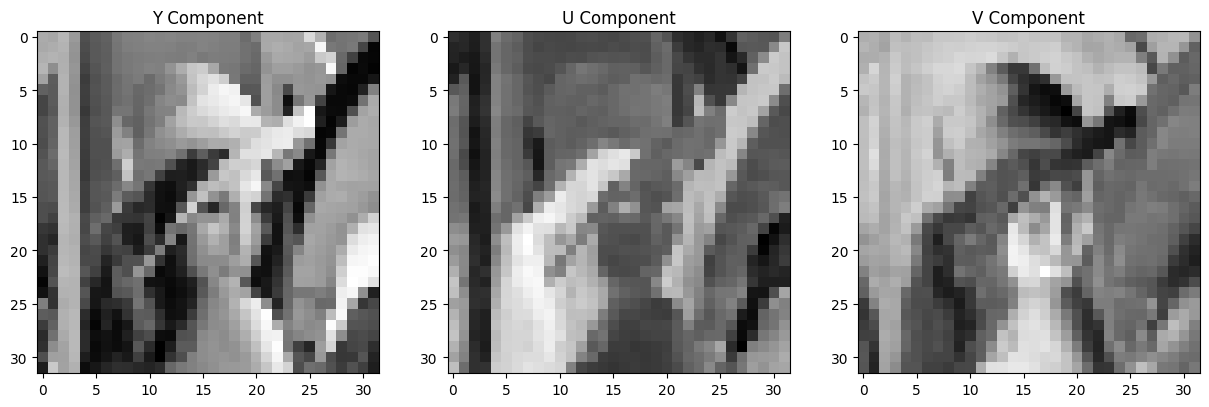

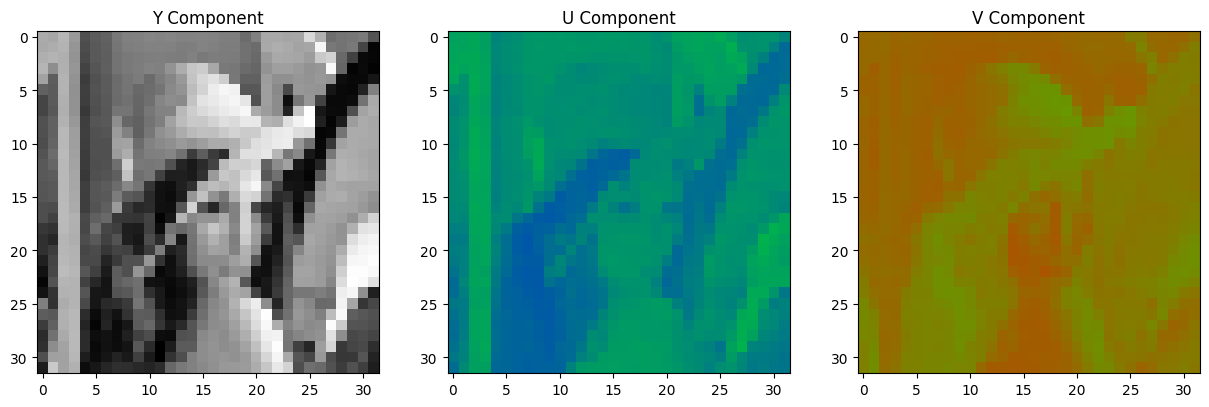

In [9]:
plot_y_u_v(y, u, v, colormap=False)
plot_y_u_v(y, u, v)


## Step 2 
### Subsampling of Color Components

In [10]:
from jpeg_implementation.subsample import subsample_u_v

In [11]:
u_subs, v_subs = subsample_u_v(u, v, *subsampling_settings)
print(len(y), len(u_subs), len(v_subs))

32 16 16


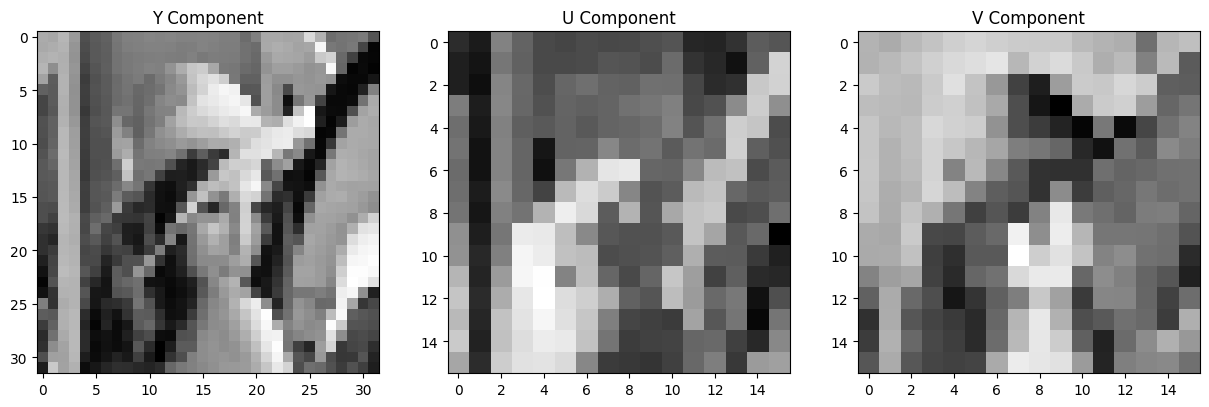

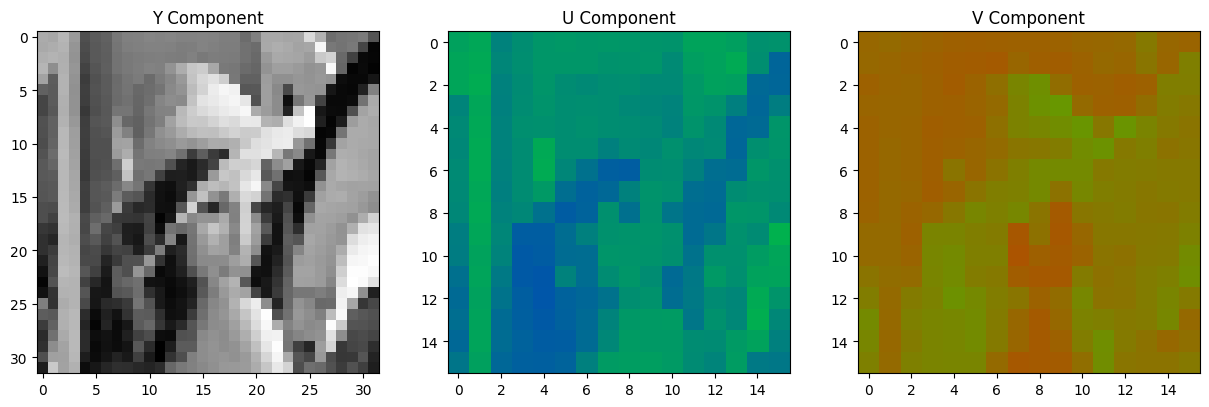

In [12]:
plot_y_u_v(y, u_subs, v_subs, colormap=False)
plot_y_u_v(y, u_subs, v_subs)


## Step 3
### Split into 8x8 Blocks

In [13]:
from jpeg_implementation.splitBlocks import split

In [14]:
split_y = split(y, block_size)
split_u = split(u_subs, block_size)
split_v = split(v_subs, block_size)

print(len(split_y), len(split_u), len(split_v))


16 4 4


[[157.94     155.598    165.419    147.076     97.664    105.64901
  109.894005 123.879   ]
 [157.082    159.18501  164.00601  143.674     95.40401  104.72
  107.976    122.477005]
 [160.658    163.316    160.8      142.457     94.105    103.72
  107.503006 120.89001 ]
 [164.501    139.251    161.099    144.528     89.746    101.43201
  108.286    121.086006]
 [151.99     106.46001  163.87102  142.24      84.778     99.69201
  105.133    115.944   ]
 [109.047005 105.090004 163.87102  141.05501   86.778     99.991005
  105.133    116.531   ]
 [ 90.735    105.019    161.55501  141.799     85.892006  99.29
  104.432    115.759   ]
 [ 91.137    103.31801  160.968    141.91301   82.707     97.589005
  103.66     122.324005]]


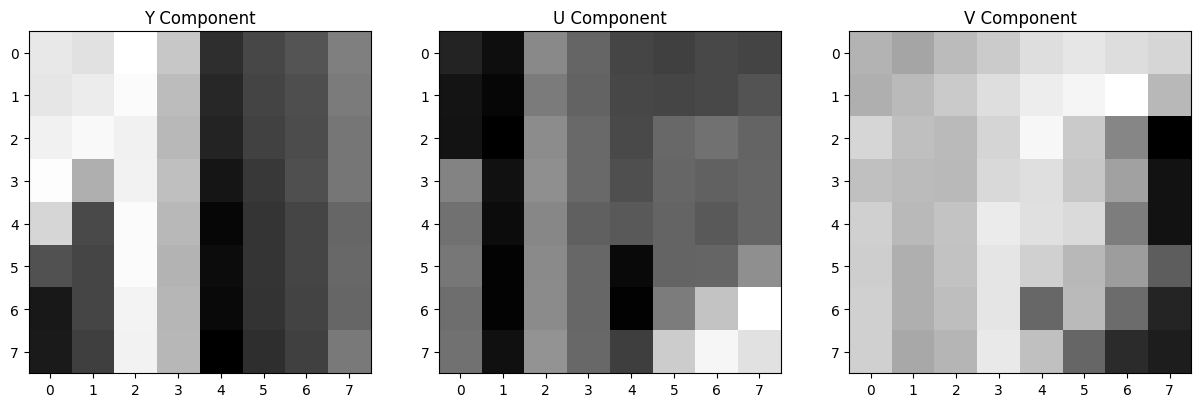

In [15]:
print(split_y[0])
plot_y_u_v(split_y[0], split_u[0], split_v[0], colormap=False)


## Step 3
### Apply dct

In [16]:
from jpeg_implementation.dct import block_dct2

In [17]:
trans_y = block_dct2(np.array(split_y) - 128, block_size)
trans_u = block_dct2(np.array(split_u) - 128, block_size)
trans_v = block_dct2(np.array(split_v) - 128, block_size)


## Step 4 
### Quantization


In [18]:
from jpeg_implementation.quantization import quantize, quantization_tables

quantization_table = quantization_tables[quantization_table_quality]

quantized_y = quantize(trans_y, quantization_table)
quantized_u = quantize(trans_u, quantization_table)
quantized_v = quantize(trans_v, quantization_table)

## Step 5
### Reordering of values, Run Length Encoding

In [19]:
from jpeg_implementation.runLengthEncode import resort_and_run_length_encode

True


In [20]:
rl_encoded_y = resort_and_run_length_encode(quantized_y, block_size)
rl_encoded_u = resort_and_run_length_encode(quantized_u, block_size)
rl_encoded_v = resort_and_run_length_encode(quantized_v, block_size)


In [21]:
print(len(rl_encoded_y), len(rl_encoded_u), len(rl_encoded_v))
print(rl_encoded_u[0])
print(rl_encoded_v[0])

328 20 42
-1.0
6.0


## Step 6
### Huffman Encoding

In [22]:
from jpeg_implementation.huffman import generate_huffman_code, encode_huffman

data = rl_encoded_y + rl_encoded_u + rl_encoded_v
huffman_code = generate_huffman_code(data)
encoded = encode_huffman(huffman_code, data)
print("original", len(data * 8), "bits")
print("encoded", len(encoded), "bits")
print("encoded + table", len(encoded) + len(huffman_code) * 16, "bits")
print("compression ratio", len(data * 8) / len(encoded))

original 3120 bits
encoded 1103 bits
encoded + table 1423 bits
compression ratio 2.828649138712602


In [23]:
huffman_code_y = generate_huffman_code(rl_encoded_y)
huff_encoded_y = encode_huffman(huffman_code_y, rl_encoded_y)

huffman_code_u = generate_huffman_code(rl_encoded_u)
huff_encoded_u = encode_huffman(huffman_code_u, rl_encoded_u)

huffman_code_v = generate_huffman_code(rl_encoded_v)
huff_encoded_v = encode_huffman(huffman_code_v, rl_encoded_v)

print("y", len(huff_encoded_y), "bits")
print("u", len(huff_encoded_u), "bits")
print("v", len(huff_encoded_v), "bits")
print("encoded", len(huff_encoded_y) + len(huff_encoded_u) + len(huff_encoded_v), "bits")
print("compression ratio", len(data * 8) / (len(huff_encoded_y) + len(huff_encoded_u) + len(huff_encoded_v)))

y 888 bits
u 50 bits
v 113 bits
encoded 1051 bits
compression ratio 2.9686013320647002


## Step 7
### Serialization

In [24]:
from jpeg_implementation.serialize import store_as_file

file_size = store_as_file("test.data", huffman_code_y, huffman_code_u, huffman_code_v, huff_encoded_y, huff_encoded_u,
                          huff_encoded_v)
print(file_size)
print(len(data) / file_size)

333
1.1711711711711712


In [25]:
# calculate effective compression ratio
import os

original_size = os.path.getsize(image_path)
compression_ratio = original_size / file_size
print("Effective Compression Ratio:", compression_ratio, "(Compared to PNG file)")

Effective Compression Ratio: 8.852852852852854 (Compared to PNG file)


## Step 8
### Deserialization

In [26]:
from jpeg_implementation.serialize import read_from_file

huffman_code_y, huffman_code_u, huffman_code_v, huff_encoded_y, huff_encoded_u, huff_encoded_v = read_from_file(
    "test.data")


## Step 9
### Decode Huffman

In [27]:
from jpeg_implementation.huffman import decode_huffman

rl_encoded_y = decode_huffman(huff_encoded_y, huffman_code_y)
rl_encoded_u = decode_huffman(huff_encoded_u, huffman_code_u)
rl_encoded_v = decode_huffman(huff_encoded_v, huffman_code_v)



## Step 10
### Decode run-length encoding + Reordering of values

In [28]:
from jpeg_implementation.runLengthEncode import unsort_and_run_length_decode

y_blocks = unsort_and_run_length_decode(rl_encoded_y, block_size)
u_blocks = unsort_and_run_length_decode(rl_encoded_u, block_size)
v_blocks = unsort_and_run_length_decode(rl_encoded_v, block_size)


## Step 11
### Apply inverse DCT

In [29]:
# todo